In [55]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [115]:
ven_info = pd.read_csv("image_data/venomous_status_metadata.csv", names=["nid", "class_id", "ven"], header=0)
train_info = pd.read_csv("image_data/train_images_metadata.csv", index_col=0)
relevant = train_info[["image_path", "class_id",]].merge(ven_info, on="class_id")
n_classes = len(ven_info)

In [116]:
def load_and_preprocess(img_path, y1, y2, img_size=(240, 240)):
    img = tf.io.read_file("image_data/train_images_small/" + img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0
    y1 = tf.one_hot(y1, depth=n_classes)
    return img, {"class_id": y1, "ven": y2}

def make_dataset(df):
    slices = (df['image_path'].values, df['class_id'].values, df['ven'].values)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(256).prefetch(tf.data.AUTOTUNE)
    return ds

In [117]:
train_paths, test_val_paths = train_test_split(relevant, test_size=0.3, random_state=42) # does shuffle
val_paths, test_paths = train_test_split(test_val_paths, test_size=0.33, random_state=42) # does shuffle
train_ds = make_dataset(train_paths)
val_ds = make_dataset(val_paths)
test_ds = make_dataset(test_paths)

In [118]:
vc = test_paths["ven"].value_counts()
vc[0] / (vc[0] + vc[1])

np.float64(0.7933130699088146)

In [93]:
import matplotlib.pyplot as plt
def plot_training_graphs():
    plt.plot(history.history['class_id_accuracy'])
    plt.plot(history.history['val_class_id_accuracy'])
    plt.plot(history.history['ven_accuracy'])
    plt.plot(history.history['val_ven_accuracy'])
    plt.title('model acc')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['class_id_acc', 'val_class_id_acc', 'ven_acc', 'val_ven_acc'], loc='upper left')

In [71]:
from tensorflow.keras.layers import Flatten, Conv2D, Dense, Input, MaxPooling2D, Dropout, Concatenate
from tensorflow.keras import losses
from tensorflow.keras import Model

In [94]:
## only output is different

inp = Input(shape=(240, 240, 3))
x = Conv2D(16, (5, 5), padding="valid")(inp)
x = MaxPooling2D(pool_size=(5,5))(x)
x = Conv2D(64, (3, 3), padding="valid")(x)
x = MaxPooling2D(pool_size=(3,3))(x)
x = Conv2D(32, (3, 3), padding="valid")(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(32, activation="relu")(x)
x = Dense(32, activation="relu")(x)
class_output = Dense(n_classes, activation="sigmoid", name='class_id')(x)
ven_output = Dense(1, activation="sigmoid", name='ven')(x)

model = Model(inputs=inp, outputs=[class_output, ven_output], name='model')

In [92]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss={'class_id': losses.CategoricalCrossentropy(), 'ven': losses.BinaryCrossentropy()},
    metrics={'class_id': 'accuracy', 'ven': 'accuracy'})

In [59]:
%%time
history = model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
1386/1662 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - class_id_accuracy: 0.0239 - class_id_loss: 5.5214 - loss: 6.0208 - ven_accuracy: 0.8022 - ven_loss: 0.4994

2025-11-15 19:53:03.524115: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - class_id_accuracy: 0.0296 - class_id_loss: 5.4508 - loss: 5.9486 - ven_accuracy: 0.8014 - ven_loss: 0.4978 - val_class_id_accuracy: 0.0333 - val_class_id_loss: 5.3429 - val_loss: 5.8448 - val_ven_accuracy: 0.7932 - val_ven_loss: 0.5022
Epoch 2/3
1386/1662 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - class_id_accuracy: 0.0349 - class_id_loss: 5.3292 - loss: 5.8187 - ven_accuracy: 0.8053 - ven_loss: 0.4895

2025-11-15 19:53:26.146168: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - class_id_accuracy: 0.0387 - class_id_loss: 5.2894 - loss: 5.7819 - ven_accuracy: 0.8016 - ven_loss: 0.4925 - val_class_id_accuracy: 0.0383 - val_class_id_loss: 5.2740 - val_loss: 5.7737 - val_ven_accuracy: 0.7932 - val_ven_loss: 0.4998
Epoch 3/3
1391/1662 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - class_id_accuracy: 0.0421 - class_id_loss: 5.2257 - loss: 5.7100 - ven_accuracy: 0.8054 - ven_loss: 0.4843

2025-11-15 19:53:46.927123: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - class_id_accuracy: 0.0453 - class_id_loss: 5.1933 - loss: 5.6809 - ven_accuracy: 0.8017 - ven_loss: 0.4877 - val_class_id_accuracy: 0.0415 - val_class_id_loss: 5.2467 - val_loss: 5.7452 - val_ven_accuracy: 0.7932 - val_ven_loss: 0.4987
CPU times: user 3min 2s, sys: 5.94 s, total: 3min 8s
Wall time: 1min 6s


In [9]:
model.evaluate(val_ds) #majd lesz test ds is eskü

416/416 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - class_id_accuracy: 0.8967 - class_id_loss: 32769262485504.0000 - loss: 43302665584640.0000 - ven_accuracy: 0.7932 - ven_loss: 10492579938304.0000


[43302665584640.0,
 32769262485504.0,
 10492579938304.0,
 0.8966969847679138,
 0.793168306350708]

In [85]:
class WeightedBinaryCrossentropy(losses.BinaryCrossentropy):
    def call(self, y_true, y_pred):
        l = super().call(y_true, y_pred)
        weights = y_true * 0.8 + (1 - y_true) * 0.2
        return tf.reduce_mean(l * weights)

In [105]:
## shared convolution

inp = Input(shape=(240, 240, 3))

#conv part
x = Conv2D(16, (5, 5), padding="valid")(inp)
x = MaxPooling2D(pool_size=(5,5))(x)
x = Conv2D(64, (3, 3), padding="valid")(x)
x = MaxPooling2D(pool_size=(3,3))(x)
x = Conv2D(32, (3, 3), padding="valid")(x)
x = MaxPooling2D()(x)
x = Flatten()(x)

# branch A: predict ven
x1 = Dense(32, activation="relu")(x)
x1 = Dense(32, activation="relu")(x1)
ven_output = Dense(1, activation="sigmoid", name='ven')(x1)

#branch B: predict c_id
x2 = Dense(32, activation="relu")(x)
x2 = Dense(32, activation="relu")(x2)
class_output = Dense(n_classes, activation="sigmoid", name='class_id')(x2)

sh_model = Model(inputs=inp, outputs=[class_output, ven_output], name='sh_model')

sh_model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss={'class_id': losses.CategoricalCrossentropy(), 'ven': WeightedBinaryCrossentropy()},
    metrics={'class_id': 'accuracy', 'ven': 'accuracy'})

In [106]:
%%time
history = sh_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - class_id_accuracy: 0.2556 - class_id_loss: 445.3447 - loss: 447.2425 - ven_accuracy: 0.5279 - ven_loss: 1.8978

2025-11-15 22:31:59.204853: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - class_id_accuracy: 0.6396 - class_id_loss: 26832.4609 - loss: 26445.5918 - ven_accuracy: 0.4479 - ven_loss: 4.6902 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 286602.0625 - val_loss: 285481.0312 - val_ven_accuracy: 0.1996 - val_ven_loss: 0.2276
Epoch 2/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - class_id_accuracy: 0.8916 - class_id_loss: 2125335.3694 - loss: 2125335.4497 - ven_accuracy: 0.7236 - ven_loss: 0.2303

2025-11-15 22:32:18.123365: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - class_id_accuracy: 0.8940 - class_id_loss: 13700289.0000 - loss: 13610628.0000 - ven_accuracy: 0.6413 - ven_loss: 0.2290 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 64854444.0000 - val_loss: 64054872.0000 - val_ven_accuracy: 0.1994 - val_ven_loss: 0.2998
Epoch 3/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - class_id_accuracy: 0.8916 - class_id_loss: 124522603.2000 - loss: 124522603.2000 - ven_accuracy: 0.7771 - ven_loss: 0.2207

2025-11-15 22:32:34.457941: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - class_id_accuracy: 0.8940 - class_id_loss: 312263904.0000 - loss: 311410112.0000 - ven_accuracy: 0.6693 - ven_loss: 0.2218 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 885887488.0000 - val_loss: 884496064.0000 - val_ven_accuracy: 0.8010 - val_ven_loss: 0.5530
Epoch 4/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - class_id_accuracy: 0.8916 - class_id_loss: 1475113396.9655 - loss: 1475113396.9655 - ven_accuracy: 0.8034 - ven_loss: 0.2203

2025-11-15 22:32:50.792222: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - class_id_accuracy: 0.8940 - class_id_loss: 2563870976.0000 - loss: 2559799552.0000 - ven_accuracy: 0.6731 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 5203850752.0000 - val_loss: 5150629888.0000 - val_ven_accuracy: 0.8010 - val_ven_loss: 1.0861
Epoch 5/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - class_id_accuracy: 0.8916 - class_id_loss: 7253534956.5793 - loss: 7253534956.5793 - ven_accuracy: 0.8032 - ven_loss: 0.2203

2025-11-15 22:33:06.985615: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - class_id_accuracy: 0.8940 - class_id_loss: 11268103168.0000 - loss: 11250246656.0000 - ven_accuracy: 0.6649 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 18752933888.0000 - val_loss: 18693312512.0000 - val_ven_accuracy: 0.8010 - val_ven_loss: 1.9746
Epoch 6/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - class_id_accuracy: 0.8916 - class_id_loss: 24226093931.6966 - loss: 24226093931.6966 - ven_accuracy: 0.8025 - ven_loss: 0.2203

2025-11-15 22:33:23.258839: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - class_id_accuracy: 0.8940 - class_id_loss: 34522660864.0000 - loss: 34456043520.0000 - ven_accuracy: 0.6518 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 66038296576.0000 - val_loss: 65600061440.0000 - val_ven_accuracy: 0.1992 - val_ven_loss: 3.2967
Epoch 7/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - class_id_accuracy: 0.8916 - class_id_loss: 67159800076.3586 - loss: 67159800076.3586 - ven_accuracy: 0.7756 - ven_loss: 0.2203

2025-11-15 22:33:39.558665: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - class_id_accuracy: 0.8940 - class_id_loss: 86537682944.0000 - loss: 86476627968.0000 - ven_accuracy: 0.6414 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 114585714688.0000 - val_loss: 114083872768.0000 - val_ven_accuracy: 0.1992 - val_ven_loss: 5.0973
Epoch 8/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - class_id_accuracy: 0.8916 - class_id_loss: 138809417389.0207 - loss: 138809417389.0207 - ven_accuracy: 0.7558 - ven_loss: 0.2203

2025-11-15 22:33:56.013308: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - class_id_accuracy: 0.8940 - class_id_loss: 178661326848.0000 - loss: 178643632128.0000 - ven_accuracy: 0.6347 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 212177813504.0000 - val_loss: 211446235136.0000 - val_ven_accuracy: 0.1992 - val_ven_loss: 7.3957
Epoch 9/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - class_id_accuracy: 0.8916 - class_id_loss: 263086573553.8759 - loss: 263086573553.8759 - ven_accuracy: 0.7752 - ven_loss: 0.2203

2025-11-15 22:34:12.453068: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - class_id_accuracy: 0.8940 - class_id_loss: 327641366528.0000 - loss: 327282982912.0000 - ven_accuracy: 0.6381 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 453141987328.0000 - val_loss: 449939472384.0000 - val_ven_accuracy: 0.1992 - val_ven_loss: 10.2459
Epoch 10/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - class_id_accuracy: 0.8916 - class_id_loss: 530872756266.3724 - loss: 530872756266.3724 - ven_accuracy: 0.7749 - ven_loss: 0.2203

2025-11-15 22:34:28.902867: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - class_id_accuracy: 0.8940 - class_id_loss: 581295013888.0000 - loss: 580562059264.0000 - ven_accuracy: 0.6352 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 877603127296.0000 - val_loss: 875174559744.0000 - val_ven_accuracy: 0.1992 - val_ven_loss: 13.6620
CPU times: user 8min 28s, sys: 14.7 s, total: 8min 42s
Wall time: 2min 48s


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - class_id_accuracy: 0.8980 - class_id_loss: 841953181696.0000 - loss: 843259969536.0000 - ven_accuracy: 0.2071 - ven_loss: 0.2245


[843259969536.0,
 841953181696.0,
 0.22454500198364258,
 0.898024320602417,
 0.20714285969734192]

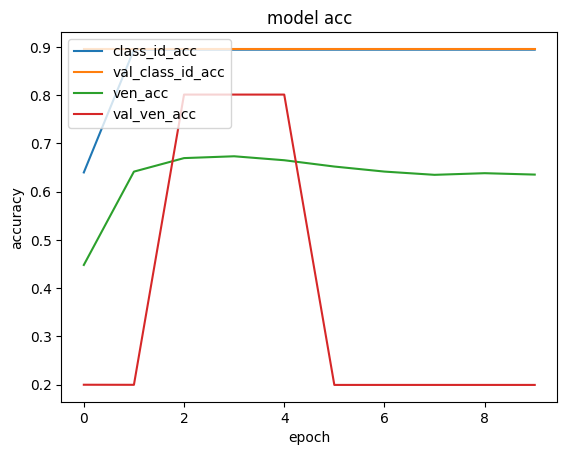

In [107]:
plot_training_graphs()
sh_model.evaluate(test_ds)

In [108]:
## concat venv to c_id

inp = Input(shape=(240, 240, 3))

#conv part
x = Conv2D(16, (5, 5), padding="valid")(inp)
x = MaxPooling2D(pool_size=(5,5))(x)
x = Conv2D(64, (3, 3), padding="valid")(x)
x = MaxPooling2D(pool_size=(3,3))(x)
x = Conv2D(32, (3, 3), padding="valid")(x)
x = MaxPooling2D()(x)
x = Flatten()(x)

# branch A: predict ven
x1 = Dense(32, activation="relu")(x)
x1 = Dense(32, activation="relu")(x1)
ven_output = Dense(1, activation="sigmoid", name='ven')(x1)

#branch B: predict c_id
x2 = Concatenate([x, ven_output])
x2 = Dense(32, activation="relu")(x)
x2 = Dense(32, activation="relu")(x2)
class_output = Dense(n_classes, activation="sigmoid", name='class_id')(x2)

vtc_model = Model(inputs=inp, outputs=[class_output, ven_output], name='sh_model')

vtc_model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss={'class_id': losses.CategoricalCrossentropy(), 'ven': WeightedBinaryCrossentropy()},
    metrics={'class_id': 'accuracy', 'ven': 'accuracy'})

In [109]:
%%time
history = vtc_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - class_id_accuracy: 0.2420 - class_id_loss: 353.3523 - loss: 356.9711 - ven_accuracy: 0.5271 - ven_loss: 3.6188

2025-11-15 22:35:44.233248: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - class_id_accuracy: 0.6352 - class_id_loss: 27437.8262 - loss: 27219.1426 - ven_accuracy: 0.5050 - ven_loss: 96.3736 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 254235.0781 - val_loss: 251075.9375 - val_ven_accuracy: 0.2072 - val_ven_loss: 296.8044
Epoch 2/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - class_id_accuracy: 0.8916 - class_id_loss: 2302432.6032 - loss: 2303234.0876 - ven_accuracy: 0.5021 - ven_loss: 801.4917

2025-11-15 22:36:03.292594: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - class_id_accuracy: 0.8940 - class_id_loss: 14484536.0000 - loss: 14408692.0000 - ven_accuracy: 0.5570 - ven_loss: 593.5723 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 62036180.0000 - val_loss: 61676860.0000 - val_ven_accuracy: 0.8009 - val_ven_loss: 0.4981
Epoch 3/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - class_id_accuracy: 0.8916 - class_id_loss: 129646760.6345 - loss: 129646770.9517 - ven_accuracy: 0.8034 - ven_loss: 0.9945

2025-11-15 22:36:19.665414: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - class_id_accuracy: 0.8940 - class_id_loss: 340808640.0000 - loss: 339638592.0000 - ven_accuracy: 0.8006 - ven_loss: 0.4504 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 1033755776.0000 - val_loss: 1027584704.0000 - val_ven_accuracy: 0.8009 - val_ven_loss: 1.5460
Epoch 4/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - class_id_accuracy: 0.8916 - class_id_loss: 1426404911.6690 - loss: 1426404911.6690 - ven_accuracy: 0.8035 - ven_loss: 0.2203

2025-11-15 22:36:36.042885: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - class_id_accuracy: 0.8940 - class_id_loss: 2516988160.0000 - loss: 2514256896.0000 - ven_accuracy: 0.8007 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 4371276288.0000 - val_loss: 4330605056.0000 - val_ven_accuracy: 0.8009 - val_ven_loss: 3.8606
Epoch 5/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - class_id_accuracy: 0.8916 - class_id_loss: 6846210074.4828 - loss: 6846210074.4828 - ven_accuracy: 0.8035 - ven_loss: 0.2204

2025-11-15 22:36:52.460400: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - class_id_accuracy: 0.8940 - class_id_loss: 10725566464.0000 - loss: 10705126400.0000 - ven_accuracy: 0.8007 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 20356935680.0000 - val_loss: 20137256960.0000 - val_ven_accuracy: 0.8009 - val_ven_loss: 7.8988
Epoch 6/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - class_id_accuracy: 0.8916 - class_id_loss: 25978206250.3724 - loss: 25978206250.3724 - ven_accuracy: 0.8035 - ven_loss: 0.2204

2025-11-15 22:37:08.871953: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - class_id_accuracy: 0.8940 - class_id_loss: 33918748672.0000 - loss: 33855662080.0000 - ven_accuracy: 0.7406 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 66041815040.0000 - val_loss: 65610579968.0000 - val_ven_accuracy: 0.8009 - val_ven_loss: 14.0045
Epoch 7/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - class_id_accuracy: 0.8916 - class_id_loss: 67825920353.1034 - loss: 67825920353.1034 - ven_accuracy: 0.8035 - ven_loss: 0.2204

2025-11-15 22:37:25.289703: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - class_id_accuracy: 0.8940 - class_id_loss: 85205876736.0000 - loss: 85130371072.0000 - ven_accuracy: 0.7037 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 109636345856.0000 - val_loss: 109013778432.0000 - val_ven_accuracy: 0.8009 - val_ven_loss: 22.2158
Epoch 8/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - class_id_accuracy: 0.8916 - class_id_loss: 133383210711.3931 - loss: 133383210711.3931 - ven_accuracy: 0.8035 - ven_loss: 0.2204

2025-11-15 22:37:41.686748: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - class_id_accuracy: 0.8940 - class_id_loss: 169366323200.0000 - loss: 169217163264.0000 - ven_accuracy: 0.6901 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 223409143808.0000 - val_loss: 220039069696.0000 - val_ven_accuracy: 0.8009 - val_ven_loss: 33.0430
Epoch 9/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - class_id_accuracy: 0.8916 - class_id_loss: 283267416346.4828 - loss: 283267416346.4828 - ven_accuracy: 0.8035 - ven_loss: 0.2204

2025-11-15 22:37:58.254218: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - class_id_accuracy: 0.8940 - class_id_loss: 315378532352.0000 - loss: 315167113216.0000 - ven_accuracy: 0.6794 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 357924864000.0000 - val_loss: 358935068672.0000 - val_ven_accuracy: 0.8009 - val_ven_loss: 46.3453
Epoch 10/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - class_id_accuracy: 0.8916 - class_id_loss: 509886031349.4069 - loss: 509886031349.4069 - ven_accuracy: 0.8034 - ven_loss: 0.2204

2025-11-15 22:38:14.924392: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - class_id_accuracy: 0.8940 - class_id_loss: 558397784064.0000 - loss: 557879918592.0000 - ven_accuracy: 0.6731 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 705217691648.0000 - val_loss: 703424626688.0000 - val_ven_accuracy: 0.8009 - val_ven_loss: 62.2987
CPU times: user 8min 30s, sys: 14.5 s, total: 8min 45s
Wall time: 2min 49s


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - class_id_accuracy: 0.8980 - class_id_loss: 671887589376.0000 - loss: 673238679552.0000 - ven_accuracy: 0.7933 - ven_loss: 0.2246


[673238679552.0,
 671887589376.0,
 0.22461146116256714,
 0.898024320602417,
 0.7933130860328674]

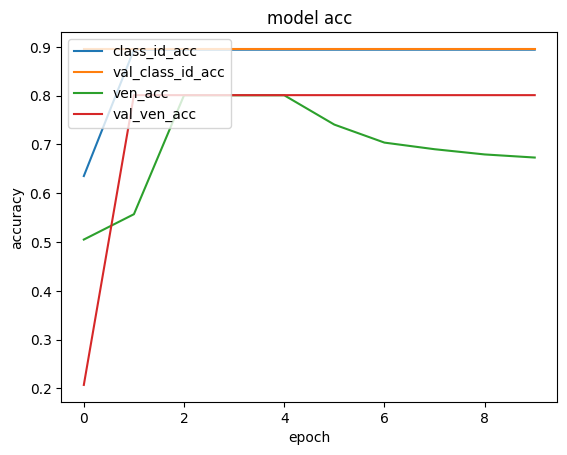

In [110]:
plot_training_graphs()
vtc_model.evaluate(test_ds)

In [111]:
## concat c_id to to ven

inp = Input(shape=(240, 240, 3))

#conv part
x = Conv2D(16, (5, 5), padding="valid")(inp)
x = MaxPooling2D(pool_size=(5,5))(x)
x = Conv2D(64, (3, 3), padding="valid")(x)
x = MaxPooling2D(pool_size=(3,3))(x)
x = Conv2D(32, (3, 3), padding="valid")(x)
x = MaxPooling2D()(x)
x = Flatten()(x)

#branch B: predict c_id
x2 = Dense(32, activation="relu")(x)
x2 = Dense(32, activation="relu")(x2)
class_output = Dense(n_classes, activation="sigmoid", name='class_id')(x2)

# branch A: predict ven
x1 = Concatenate([x, class_output])
x1 = Dense(32, activation="relu")(x)
x1 = Dense(32, activation="relu")(x1)
ven_output = Dense(1, activation="sigmoid", name='ven')(x1)

ctv_model = Model(inputs=inp, outputs=[class_output, ven_output], name='sh_model')

ctv_model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss={'class_id': losses.CategoricalCrossentropy(), 'ven': WeightedBinaryCrossentropy()},
    metrics={'class_id': 'accuracy', 'ven': 'accuracy'})

In [119]:
%%time
history = ctv_model.fit(train_ds, validation_data=val_ds, epochs=10, verbose=True)

Epoch 1/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - class_id_accuracy: 0.8916 - class_id_loss: 2208310264485.9585 - loss: 2208310264485.9585 - ven_accuracy: 0.8019 - ven_loss: 0.2203

2025-11-15 22:47:49.674251: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - class_id_accuracy: 0.8940 - class_id_loss: 2371654254592.0000 - loss: 2371477569536.0000 - ven_accuracy: 0.6451 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 2349012090880.0000 - val_loss: 2334824071168.0000 - val_ven_accuracy: 0.1990 - val_ven_loss: 0.2213
Epoch 2/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - class_id_accuracy: 0.8916 - class_id_loss: 3007084742528.8828 - loss: 3007084742528.8828 - ven_accuracy: 0.7752 - ven_loss: 0.2203

2025-11-15 22:48:05.816150: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - class_id_accuracy: 0.8940 - class_id_loss: 3337990963200.0000 - loss: 3337012117504.0000 - ven_accuracy: 0.6380 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 3851566448640.0000 - val_loss: 3817940975616.0000 - val_ven_accuracy: 0.1990 - val_ven_loss: 0.2213
Epoch 3/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - class_id_accuracy: 0.8916 - class_id_loss: 4222745103564.7998 - loss: 4222745103564.7998 - ven_accuracy: 0.7752 - ven_loss: 0.2203

2025-11-15 22:48:22.004938: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - class_id_accuracy: 0.8940 - class_id_loss: 4452598677504.0000 - loss: 4450366259200.0000 - ven_accuracy: 0.6380 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 5884992290816.0000 - val_loss: 5839245541376.0000 - val_ven_accuracy: 0.1990 - val_ven_loss: 0.2213
Epoch 4/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - class_id_accuracy: 0.8916 - class_id_loss: 5610063598443.6963 - loss: 5610063598443.6963 - ven_accuracy: 0.7737 - ven_loss: 0.2203

2025-11-15 22:48:38.253104: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - class_id_accuracy: 0.8940 - class_id_loss: 5890867986432.0000 - loss: 5889710882816.0000 - ven_accuracy: 0.6251 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 6606126841856.0000 - val_loss: 6565605146624.0000 - val_ven_accuracy: 0.1990 - val_ven_loss: 0.2213
Epoch 5/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - class_id_accuracy: 0.8916 - class_id_loss: 6930583475842.6484 - loss: 6930583475842.6484 - ven_accuracy: 0.7731 - ven_loss: 0.2203

2025-11-15 22:48:54.533406: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - class_id_accuracy: 0.8940 - class_id_loss: 7387663040512.0000 - loss: 7386297270272.0000 - ven_accuracy: 0.6217 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 8732102623232.0000 - val_loss: 8653200424960.0000 - val_ven_accuracy: 0.1990 - val_ven_loss: 0.2213
Epoch 6/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - class_id_accuracy: 0.8916 - class_id_loss: 9455024464832.4414 - loss: 9455024464832.4414 - ven_accuracy: 0.7719 - ven_loss: 0.2203

2025-11-15 22:49:10.837352: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - class_id_accuracy: 0.8940 - class_id_loss: 9402462502912.0000 - loss: 9405303095296.0000 - ven_accuracy: 0.6149 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 9237636841472.0000 - val_loss: 9204951678976.0000 - val_ven_accuracy: 0.1990 - val_ven_loss: 0.2213
Epoch 7/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - class_id_accuracy: 0.8916 - class_id_loss: 11509270116140.1387 - loss: 11509270116140.1387 - ven_accuracy: 0.7705 - ven_loss: 0.2203

2025-11-15 22:49:27.160338: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - class_id_accuracy: 0.8940 - class_id_loss: 11988005552128.0000 - loss: 11985544544256.0000 - ven_accuracy: 0.6083 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 14288196468736.0000 - val_loss: 14122050650112.0000 - val_ven_accuracy: 0.1990 - val_ven_loss: 0.2213
Epoch 8/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - class_id_accuracy: 0.8916 - class_id_loss: 14519278306635.9180 - loss: 14519278306635.9180 - ven_accuracy: 0.7687 - ven_loss: 0.2203

2025-11-15 22:49:43.504407: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - class_id_accuracy: 0.8940 - class_id_loss: 14242804662272.0000 - loss: 14236290908160.0000 - ven_accuracy: 0.5987 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 16256939851776.0000 - val_loss: 16083970949120.0000 - val_ven_accuracy: 0.1990 - val_ven_loss: 0.2213
Epoch 9/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - class_id_accuracy: 0.8916 - class_id_loss: 18027007225997.2422 - loss: 18027007225997.2422 - ven_accuracy: 0.7511 - ven_loss: 0.2203

2025-11-15 22:49:59.847571: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - class_id_accuracy: 0.8940 - class_id_loss: 17394663686144.0000 - loss: 17389196410880.0000 - ven_accuracy: 0.6049 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 18877383704576.0000 - val_loss: 18812017573888.0000 - val_ven_accuracy: 0.1990 - val_ven_loss: 0.2213
Epoch 10/10
145/182 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - class_id_accuracy: 0.8916 - class_id_loss: 21387936619018.5938 - loss: 21387936619018.5938 - ven_accuracy: 0.7719 - ven_loss: 0.2203

2025-11-15 22:50:16.224992: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - class_id_accuracy: 0.8940 - class_id_loss: 21225472524288.0000 - loss: 21216666583040.0000 - ven_accuracy: 0.6149 - ven_loss: 0.2215 - val_class_id_accuracy: 0.8956 - val_class_id_loss: 20301115031552.0000 - val_loss: 20220204810240.0000 - val_ven_accuracy: 0.1990 - val_ven_loss: 0.2213
CPU times: user 8min 21s, sys: 13.3 s, total: 8min 35s
Wall time: 2min 42s


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - class_id_accuracy: 0.8980 - class_id_loss: 19290480705536.0000 - loss: 19348880097280.0000 - ven_accuracy: 0.2067 - ven_loss: 0.2246


[19348880097280.0,
 19290480705536.0,
 0.22460757195949554,
 0.898024320602417,
 0.20668692886829376]

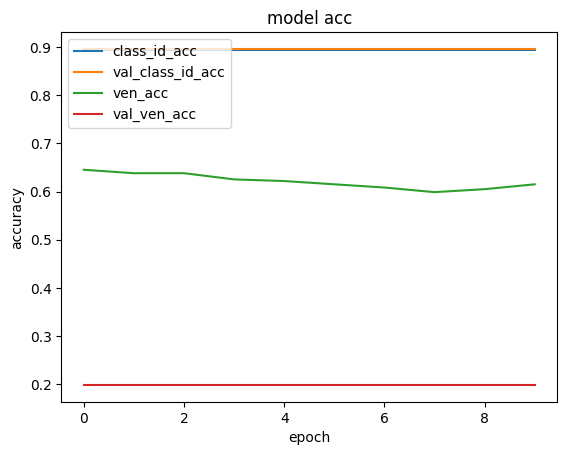

In [120]:
plot_training_graphs()
ctv_model.evaluate(test_ds)

In [121]:
sh = sh_model.predict(test_ds)
vtc = vtc_model.predict(test_ds)
ctv = ctv_model.predict(test_ds)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


In [124]:
sh

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(6580, 296), dtype=float32),
 array([[0.5001207],
        [0.5001207],
        [0.5001207],
        ...,
        [0.5001207],
        [0.5001207],
        [0.5001207]], shape=(6580, 1), dtype=float32)]

In [126]:
sh[1].shape, np.sum(sh[1] > 0.5), np.sum(vtc[1] > 0.5), np.sum(ctv[1] > 0.5)

((6580, 1), np.int64(6577), np.int64(0), np.int64(6580))

In [129]:
np.sum(sh[0] != vtc[0]), np.sum(sh[0] != ctv[0]), np.sum(ctv[0] != vtc[0])

(np.int64(0), np.int64(0), np.int64(0))